# PDB-CCD TM

## Import Packages and Datasets

In [1]:
import datetime
from collections import defaultdict, Counter

import numpy as np
import matplotlib.pyplot as plt

from qcportal.singlepoint import QCSpecification
from qcportal.singlepoint import SinglepointDriver
from qcportal.optimization import OptimizationSpecification
import qcportal
from qcportal.external import scaffold
from qcfractal.snowflake import FractalSnowflake


## Get Final Molecules from Previous Optimization

In [2]:
client = qcportal.PortalClient(
    "https://api.qcarchive.molssi.org:443/", 
#    username=os.environ['QCARCHIVE_USER'],
#    password=os.environ['QCARCHIVE_PASSWORD'],
    cache_dir=".",
)

In [3]:
ds = client.get_dataset("optimization", "TM Benchmark Optimization Dataset Step 1 v0.0")
molecules = {entry_name: rec.final_molecule for entry_name, _, rec in ds.iterate_records(status="complete")}
entries = {entry.name: entry for entry in ds.iterate_entries(entry_names=list(molecules.keys()))}

In [4]:
elements = sorted(set([str(sym) for mol in molecules.values() for sym in mol.symbols]))
charges = sorted(set([int(mol.molecular_charge) for mol in molecules.values()]))
molecular_weights = [float(mol.extras['molecular_weight']) for mol in molecules.values()]
metals = [list(mol.extras['metals'].keys())[0] if mol.extras['metals'].keys() else None for mol in molecules.values()]
multiplicities = defaultdict(list)
for entry_name, mol in molecules.items():
    name = "-".join(entry_name.split("-")[:-1])
    multiplicities[name].append(int(mol.molecular_multiplicity))

## Create Dataset

In [5]:
snowflake = FractalSnowflake()
client = snowflake.client()

In [6]:
dataset_name = "TM Benchmark Optimization Dataset Step 2 v0.0"
tagline = "Diverse set of conformers for single metal complexes with Pd, Fe, Zn, Cu, Mg, Li and charge of {-1,0,+1}, with some organic molecules, all undergoing step 2, high level of theory final optimization."
description = (
    """
    This dataset includes single metal complexes with: {'Pd', 'Fe', 'Zn', 'Mg', 'Cu', 'Li'}, and the non-metals:
    {'C', 'H', 'P', 'S', 'O', 'N', 'F', 'Cl', 'Br'}, with a complex charge of {-1,0,+1}. Additionally, there are 
    some organic molecules for benchmarking purposes. All molecules are taken from those completed optimizations 
    in the optimization dataset "TM Benchmark Optimization Dataset Step 1 v0.0". These complexes are optimized 
    at a higher level of theory with SCS-MP2 and SCS-MP3 with and without frozen core. The molecular weight min,
    mean, and max are 81, 420, and 1026, respectively. There are 75 unique molecules, each transition metal 
    complex is submitted with multiplicities that completed on the previous step to assess the spin state.
    """
)
dataset = client.add_dataset( # https://docs.qcarchive.molssi.org/user_guide/qcportal_reference.html
    "optimization",
    dataset_name,
    tagline=tagline,
    description=description,
    tags=["openff"],
    provenance={
        "qcportal": qcportal.__version__,
    },
    default_tag="openff",
    extras={
        "submitter": "jaclark5",
        "creation_date": str(datetime.date.today()),
        'collection_type': 'OptimizationDataset',
        "long_description": description,
        'long_description_url': f'https://github.com/openforcefield/qca-dataset-submission/tree/master/submissions/2025-12-17-{dataset_name.replace(" ", "-")}',
        "short_description": tagline,
        "dataset_name": dataset_name,
        "elements": elements,
    },
)

In [7]:
spec_types = [
    ["scs-mp3", "aug-cc-pvtz-dk", True],
    ["scs-mp3", "aug-cc-pvtz-dk", False],
    ["scs-mp2", "aug-cc-pvtz-dk", True],
    ["scs-mp2", "aug-cc-pvtz-dk", False],
]
for method, basis, fc in spec_types:
    spec = OptimizationSpecification(
        program='geometric',
        qc_specification=QCSpecification(
            program='psi4',
            driver=SinglepointDriver.deferred,
            method=method,
            basis=basis,
            keywords={
                'maxiter': 500, 
                'scf_properties': ['dipole', 'quadrupole', 'wiberg_lowdin_indices', 'mayer_indices', 
                                   'lowdin_charges', 'lowdin_spins', 'mulliken_charges'],
                'function_kwargs': {'properties': ['dipole_polarizabilities']},
                'properties_origin': ['COM'],
                'reference': 'uhf',
                "print": 3,
                "freeze_core": True,
            },
        ),
        keywords={
            'tmax': 0.3,
            'check': 0,
            'qccnv': False,
            'reset': True,
            'trust': 0.1,
            'molcnv': False,
            'enforce': 0.0,
            'epsilon': 1e-05,
            'maxiter': 500,
            'coordsys': 'dlc',
            'constraints': {},
            'convergence_set': 'GAU',
        }, # keywords for geometric
    )
    label = "-fc" if fc else ""
    dataset.add_specification(name=f"{method}/{basis}{label}", specification=spec)

In [8]:
for name, mol in molecules.items():
    dataset.add_entry(name, mol)

In [9]:
scaffold.to_json(dataset, compress=True)

## Make Outputs

In [10]:
print("Elements:", elements)
print("Charges:", charges)
print(
    "Molecular Weight (min mean max):", 
    int(np.min(molecular_weights)), 
    int(np.mean(molecular_weights)), 
    int(np.max(molecular_weights)),
)           
print("Number of Molecules:", len(multiplicities))
print("Number of Conformers:", len(multiplicities))
print("Number of conformers (min mean max):", 1, 1, 1)
n_multiplicities = [len(x) for x in multiplicities.values()]
print("Number of multiplicities per molecule (min mean max):", int(np.min(n_multiplicities)), int(np.mean(n_multiplicities)), int(np.max(n_multiplicities)))


Elements: ['Br', 'C', 'Cl', 'Cu', 'F', 'Fe', 'H', 'Li', 'Mg', 'N', 'O', 'P', 'Pd', 'S', 'Zn']
Charges: [-1, 0, 1]
Molecular Weight (min mean max): 81 421 1026
Number of Molecules: 76
Number of Conformers: 76
Number of conformers (min mean max): 1 1 1
Number of multiplicities per molecule (min mean max): 1 2 3


## Play with Summary

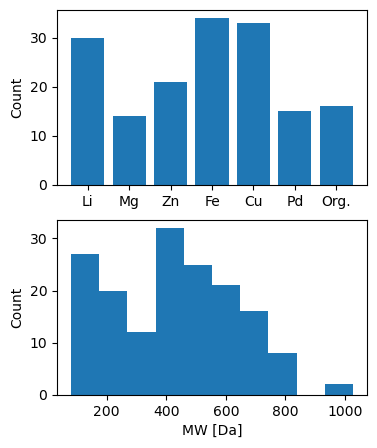

In [11]:
metals_summary = Counter(metals)
metals_summary["Org."] = metals_summary.pop(None)
labels = list(metals_summary.keys())
values = list(metals_summary.values())

fig, axs = plt.subplots(2, 1, figsize=(4,5))
labels = list(metals_summary.keys())
values = list(metals_summary.values())
axs[0].bar(range(len(values)), values);
axs[0].set_xticks(range(len(values)), labels);
axs[0].set_ylabel("Count")

axs[1].hist(molecular_weights);
axs[1].set_ylabel("Count");
axs[1].set_xlabel("MW [Da]");

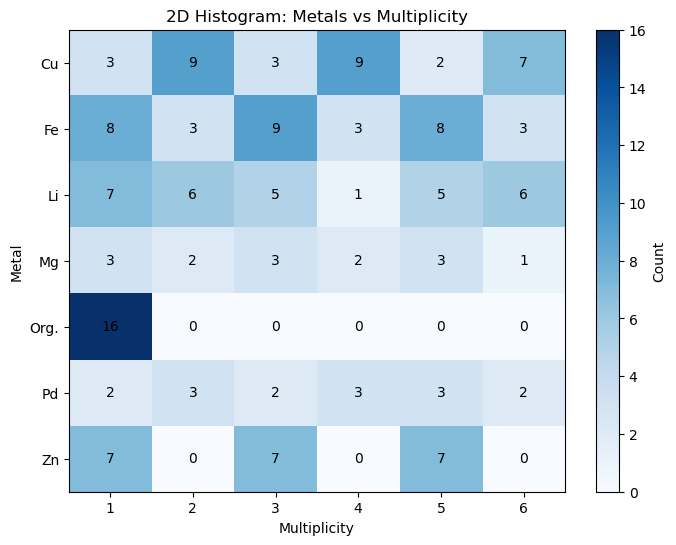

In [12]:
# Map name to metal
name_to_metal = {}
for entry_name, mol in molecules.items():
    fragments = entry_name.split("-")
    name = "-".join(fragments[:-1])
    metal = list(mol.extras['metals'].keys())[0] if mol.extras['metals'] else 'Org.'
    name_to_metal[name] = metal

# Count occurrences
counts = defaultdict(lambda: defaultdict(int))
for name, mults in multiplicities.items():
    metal = name_to_metal[name]
    for mult in mults:
        counts[metal][mult] += 1

# Prepare data for plotting
metals_unique = sorted(counts.keys())
mults_unique = sorted(set(mult for metal_counts in counts.values() for mult in metal_counts))
data = np.zeros((len(metals_unique), len(mults_unique)))
for i, m in enumerate(metals_unique):
    for j, mult in enumerate(mults_unique):
        data[i, j] = counts[m][mult]

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(data, cmap='Blues', aspect='auto')
ax.set_xticks(range(len(mults_unique)))
ax.set_xticklabels(mults_unique)
ax.set_yticks(range(len(metals_unique)))
ax.set_yticklabels(metals_unique)
ax.set_xlabel('Multiplicity')
ax.set_ylabel('Metal')

# Add text labels
for i in range(len(metals_unique)):
    for j in range(len(mults_unique)):
        ax.text(j, i, int(data[i, j]), ha="center", va="center", color="black")

plt.title('2D Histogram: Metals vs Multiplicity')
plt.colorbar(im, ax=ax, label='Count')
plt.show()